# B2. モニタリング結果の分析

このノートブックを実行する時のヒント：   
- このノートブックは大容量のRawデータを読み込むため、<span style="color: orange; ">メモリー8GB以上のインスタンス</span>で実行してください
- KernelはPython3（Data Science）で動作確認をしています。
- ステップBでは、推論リクエストを実行して、モニタリングのレポートが出力されるのを待つ必要があります。モニタリングをhourlyでスケジュールした場合は、推論を実行した時間の翌時間（16時台に推論を実行した場合は17時）の0分から20分の間にモニタリングジョブが実行されるので、Processing Jobの実行状況を確認して、完了を待ってから続行してください。
- デフォルトではSageMakerのデフォルトBucketを利用します。必要に応じて変更することも可能です。
- 実際に動かさなくても出力を確認できるように一部のセルのアウトプットを残しています。きれいな状態から実行したい場合は、右クリックメニューから "Clear All Outputs"を選択して出力をクリアしてから始めてください。

複数のノートブックで共通で使用する変数

In [11]:
# エンドポイント名を指定する
endpoint_name = 'nyctaxi-xgboost-endpoint'

# エンドポイントConfigの名前を指定する
endpoint_config_name = '{}-config'.format(endpoint_name)

# データ品質のモニタリングスケジュールの名前を指定する
data_quality_monitoring_schedule = f'{endpoint_name}-data-quality-schedule'

# SageMaker default bucketをModel Monitorのバケットとして使用
# それ以外のバケットを使用している場合はここで指定する
import sagemaker
bucket = sagemaker.Session().default_bucket()

## オプションA この環境で推論リクエストを実行する
推論リクエストの実行後に、次の周期のモニタリングジョブの稼働を待つ必要があります

In [12]:
# ベースラインの出力先Prefixを設定する
baseline_prefix = 'model_monitor/data_quality_baseline'

# 時系列での可視化のために、複数のレポートに共通するPrefixを設定する
report_prefix = 'model_monitor/data_quality_monitoring_report'

推論を実行して次のモニタリング周期まで待つ

In [13]:
# 推論を実行する日付を指定する
prediction_target_date = '2021-08-15'

# データのサンプリングレートを指定する（モデル作成時の設定に合わせる）
sampling_rate = 20

In [14]:
import os
import boto3
import pandas as pd
import time
from datetime import datetime
import model_utils

In [15]:
def get_data_for_pred(target, sampling_rate):
    previous_year, previous_month = model_utils.get_previous_year_month(target.year, target.month)
    df_previous_month = model_utils.get_raw_data(previous_year, previous_month, sampling_rate)
    df_current_month = model_utils.get_raw_data(target.year, target.month, sampling_rate)
    df_data = pd.concat([df_previous_month, df_current_month])
    del df_previous_month
    del df_current_month

    # Extract features
    df_features = model_utils.extract_features(df_data)
    df_features = model_utils.filter_current_month(df_features, target.year, target.month)
    
    return df_features

In [16]:
target_date = pd.to_datetime(prediction_target_date)
print('Loading data for', target_date.strftime('%Y-%m'))
df_features = get_data_for_pred(target_date, sampling_rate)
        
# Exec prediction for the target date
print('Predicting', target_date, endpoint_name)
df_pred = df_features[df_features.index == target_date].copy()
df_pred[['pred', 'inference_id']] = model_utils.exec_prediction(endpoint_name, df_pred)

print('')
print(f'{prediction_target_date} データの推論リクエストを実行しました')
print('次の時刻の0分から20分の間にモニタリングジョブが実行されます')

Loading data for 2021-08
Predicting 2021-08-15 00:00:00 nyctaxi-xgboost-endpoint

2021-08-15 データの推論リクエストを実行しました
次の時刻の0分から20分の間にモニタリングジョブが実行されます


#### モニタリングジョブが出力したレポートを確認する

In [23]:
!aws s3 ls s3://$bucket/$report_prefix/ --recursive

2022-12-15 12:24:21      24055 model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/15/12/constraint_violations.json
2022-12-15 12:21:07      24353 model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/15/12/constraints.json
2022-12-15 12:21:07     408519 model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/15/12/statistics.json
2022-12-16 11:21:47      25817 model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/16/11/constraint_violations.json
2022-12-16 11:18:43      24353 model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/16/11/constraints.json
2022-12-16 11:18:43     568365 model_monitor/data_quality_monitoring_report/nyctaxi-xg

<span style="color: orange; ">正常にレポートが出力されていれば、上のセルにS3上のレポートファイルが出力されるので、model_monitor/xxxx/YYYY/MM/DD/HHまでをspecific_report_prefixにセットしてください</span>

In [24]:
# モニタリングジョブで出力された特定のレポートのPrefixを設定する
specific_report_prefix = 'model_monitor/data_quality_monitoring_report/nyctaxi-xgboost-endpoint/nyctaxi-xgboost-endpoint-data-quality-schedule/2022/12/16/11'

## オプションB モニタリングの実行をまたずにサンプルで分析してみる
推論の実行後にモニタリングジョブを待つのは時間がかかるため、サンプルコードに含まれるレポートで分析や可視化を試したい場合は、以下のセルを実行してS3バケットにサンプルのレポートをアップロードしてください  
ご自身のレポートで可視化を行う場合は、このセルはスキップしてください

In [3]:
sagemaker.s3.S3Uploader.upload('data_quality_samples', f's3://{bucket}/model_monitor/data_quality_samples')

baseline_prefix = 'model_monitor/data_quality_samples/baseline'
report_prefix = 'model_monitor/data_quality_samples/reports'
specific_report_prefix = 'model_monitor/data_quality_samples/reports/2020/03/16/01'

## B2-2. Model Monitorインスタンスから直前に実行したモニタリングのレポートを取得する

In [25]:
import random
import boto3
import numpy as np
import pandas as pd

import sagemaker
from sagemaker import model_monitor
from sagemaker import get_execution_role
import monitor_utils as mu

%matplotlib inline

In [26]:
default_monitor = model_monitor.DefaultModelMonitor(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.t3.medium',
    volume_size_in_gb=100,
    max_runtime_in_seconds=3600,
)
existing_model_monitor = default_monitor.attach(monitor_schedule_name=data_quality_monitoring_schedule)
statistics = existing_model_monitor.latest_monitoring_statistics()
if statistics:
    statistics.body_dict

## B2-3. S3バケットからベースラインとレポートを取得する

In [27]:
# Get baselines
baseline_statistics = model_monitor.Statistics.from_s3_uri(f's3://{bucket}/{baseline_prefix}/statistics.json').body_dict
baseline_constraints = model_monitor.Constraints.from_s3_uri(f's3://{bucket}/{baseline_prefix}/constraints.json').body_dict

# Get report stats and constraint
statistics = model_monitor.Statistics.from_s3_uri(f's3://{bucket}/{specific_report_prefix}/statistics.json').body_dict
constraints = model_monitor.Constraints.from_s3_uri(f's3://{bucket}/{specific_report_prefix}/constraints.json').body_dict
constraint_violations = model_monitor.ConstraintViolations.from_s3_uri(f's3://{bucket}/{specific_report_prefix}/constraint_violations.json').body_dict

In [ ]:
# ベースライン統計の表示
baseline_statistics

In [ ]:
# レポートの統計の表示
statistics

In [ ]:
# レポートの制約の表示
constraints

In [ ]:
# レポートの制約違反の表示
constraint_violations

## B2-4. 単一のレポートを可視化する

### 制約違反を可視化する

In [ ]:
mu.show_violation_df(
    baseline_statistics=baseline_statistics,
    latest_statistics=statistics,
    violations=constraint_violations['violations'],
)

### 分布を可視化する

ベースラインとレポートの比較

,num_present,num_missing,mean,sum,std_dev,min,max
extra_mean_16slot,192,0,0.956503,183.648663,0.316831,0.404255,1.873249
fare_amount_mean_100slot,192,0,14.976413,2875.471358,3.722576,10.900000,35.083333
fare_amount_mean_104slot,192,0,14.983530,2876.837749,3.725141,10.900000,35.083333
fare_amount_mean_16slot,192,0,14.443428,2773.138159,2.507316,11.177522,26.997273
history_100slots,192,0,200.354167,38468.000000,111.425609,6.000000,405.000000
history_1338slots,192,0,162.083333,31120.000000,99.804775,6.000000,437.000000
history_1346slots,192,0,168.510417,32354.000000,96.432402,6.000000,437.000000
history_144slots,192,0,200.614583,38518.000000,110.895256,6.000000,378.000000
history_156slots,192,0,201.479167,38684.000000,109.814235,6.000000,378.000000
history_164slots,192,0,203.760417,39122.000000,106.980016,6.000000,378.000000


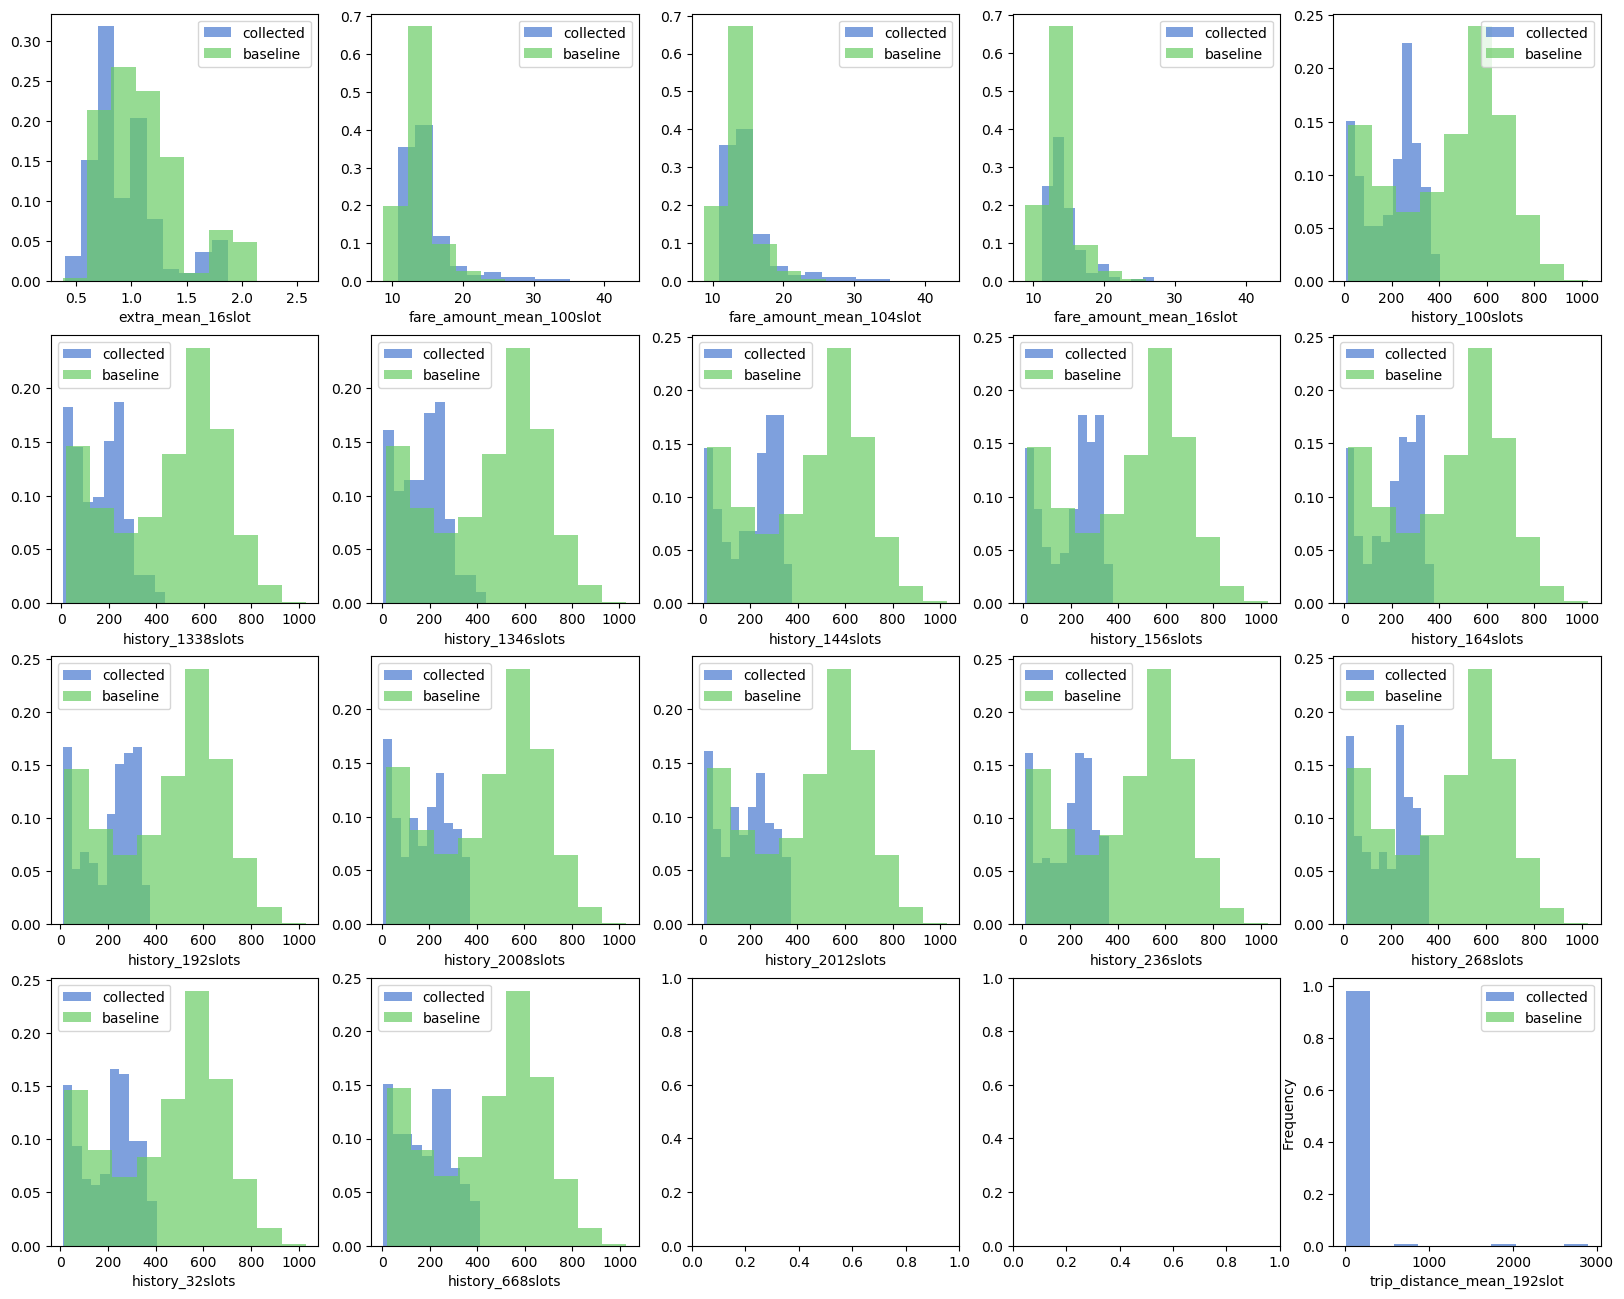

In [33]:
# Get baselines
baseline_statistics = model_monitor.Statistics.from_s3_uri(f's3://{bucket}/{baseline_prefix}/statistics.json').body_dict
statistics = model_monitor.Statistics.from_s3_uri(f's3://{bucket}/{specific_report_prefix}/statistics.json').body_dict

# Parse statistics
features = mu.get_features(statistics)
feature_baselines = mu.get_features(baseline_statistics)

# Select 20 random features
selected_list = sorted(random.sample(list(features.items()), k=20))
selected_features = {x[0]:x[1] for x in selected_list}

# Visualizep
mu.show_distributions(selected_features, feature_baselines)

## B2-4. 複数のモニタリング期間にまたがった傾向を把握する

- サンプルレポートを利用する場合は、S3にレポートがアップロード済みなのでそのまま実行してください
- 推論リクエストを実行してモニタリングジョブを実行する場合は、`step-0-prediction.ipynb` を利用して複数のモニタリング周期にまたがった推論リクエストを生成してください

特定の特徴量に着目して複数期間の分布の変化を可視化する

In [13]:
def get_reports(report_bucket, report_location, file_type):
    s3 = boto3.client('s3')
    assert file_type in ('statistics', 'constraints', 'violations')
    
    resp = s3.list_objects(Bucket=report_bucket, Prefix=report_location)
    report_files = [x['Key'] for x in resp['Contents'] if x['Key'].endswith(f'{file_type}.json')]

    monitoring_reports = {}
    for key in sorted(report_files):
        report_s3uri = f's3://{report_bucket}/{key}'
        
        if file_type == 'statistics':
            body_dict = model_monitor.Statistics.from_s3_uri(report_s3uri).body_dict
        elif file_type == 'constraints':
            body_dict = model_monitor.Constraints.from_s3_uri(report_s3uri).body_dict
        elif file_type == 'violations':
            body_dict = model_monitor.ConstraintViolations.from_s3_uri(report_s3uri).body_dict
        else:
            print('Unexpected file type')
            return 
        
        report_time = pd.to_datetime('-'.join(key.split('/')[-5:-1]), format='%Y-%m-%d-%H')
        monitoring_reports[report_time] = body_dict

    return monitoring_reports

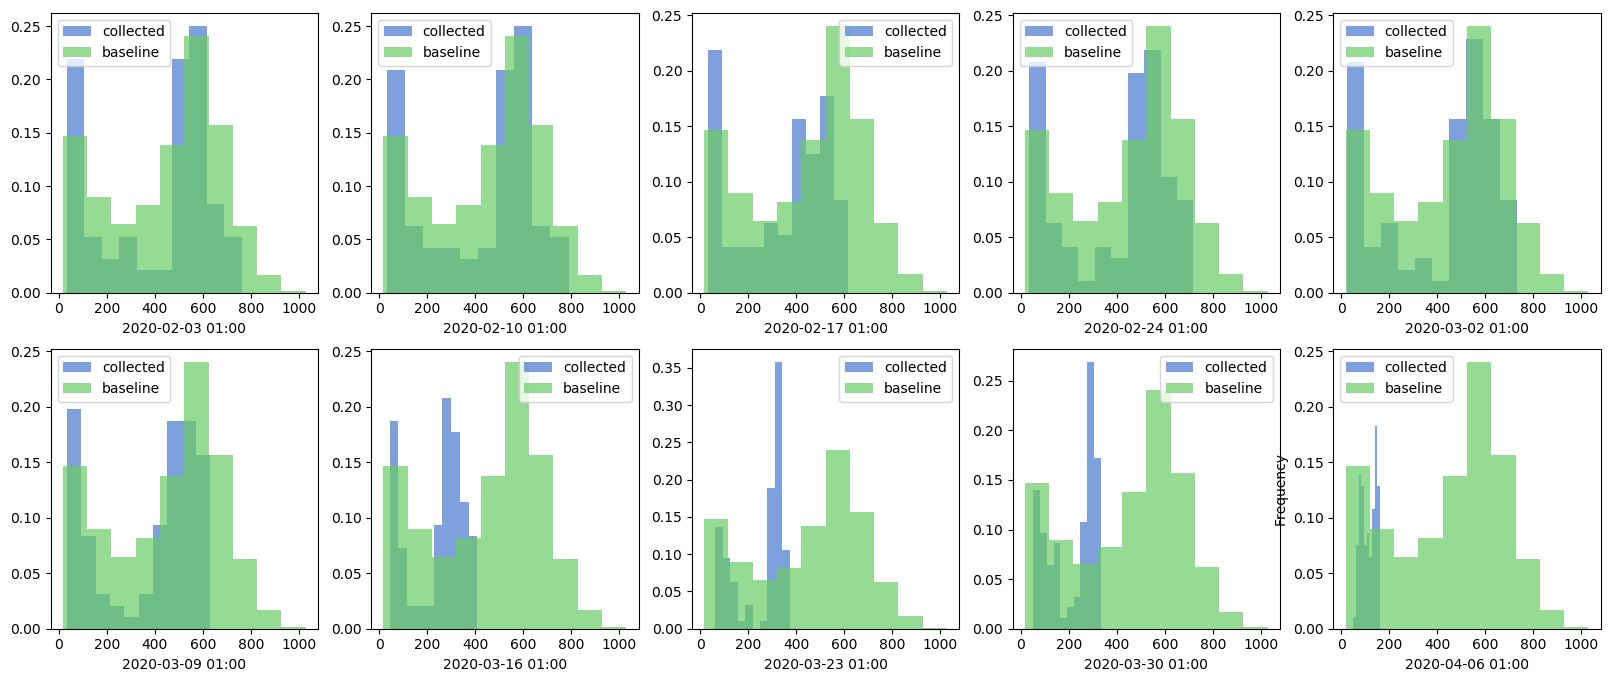

In [14]:
# Get baselines
baseline_statistics = model_monitor.Statistics.from_s3_uri(f's3://{bucket}/{baseline_prefix}/statistics.json').body_dict
feature_baselines = mu.get_features(baseline_statistics)

# statisticsの複数期間にまたがるレポートを取得する
statistics_reports = get_reports(bucket, report_prefix, 'statistics')

# 特定の特徴量に着目して時系列での変化を可視化する
mu.show_distribution_trend(statistics_reports, 'pickup_count', feature_baselines)

#### ベースライン・ドリフトの推移を可視化

In [15]:
def extract_baseline_drift(feature_names, violation_reports):
    drift_distance_dict = {}
    for feature_name in feature_names:
        drift_distance = []
        for key, report_violations in violation_reports.items():

            target_violations = [x for x in report_violations['violations'] if x['feature_name']==feature_name and x['constraint_check_type']=='baseline_drift_check']
            if len(target_violations) == 0:
                drift_distance.append(0)
            else:
                violation = target_violations[0]
                drift_distance.append(float(violation['description'].split(' ')[3]))

        drift_distance_dict[feature_name] = drift_distance

    df = pd.DataFrame(drift_distance_dict, index=[x for x in violation_reports])
    return df

In [16]:
# Get and parse violation reports
violation_reports = get_reports(bucket, report_prefix, 'violations')

feature_names = [x['name'] for x in baseline_statistics['features']]
df_violations = extract_baseline_drift(feature_names, violation_reports)

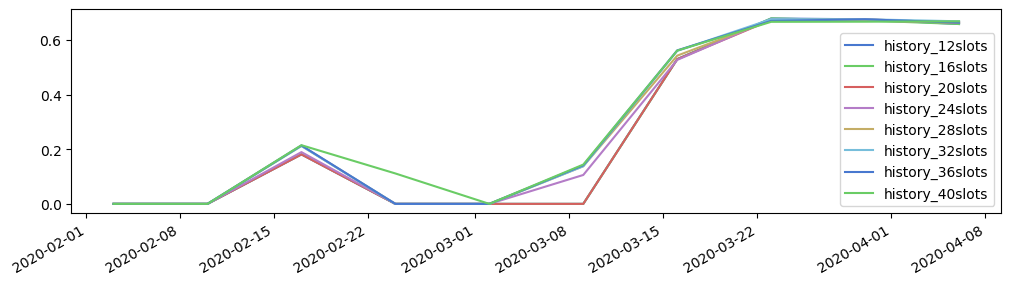

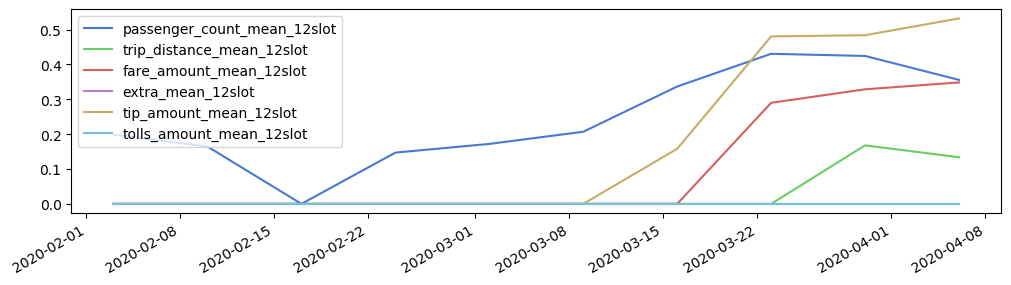

In [17]:
history_cols = [x for x in df_violations.columns if x.startswith('history')][:8]
df_violations[history_cols].plot(figsize=(12,3))

other_cols = [x for x in df_violations.columns if not x.startswith('history') and x.endswith('12slot')][:10]
df_violations[other_cols].plot(figsize=(12,3))

#### Statisticsレポート内の要約統計量の推移を可視化

In [18]:
def extract_stats_value(feature_names, statistics_reports, target_metric):
    stats_summary = {}

    for feature_name in feature_names:
        values = []
        for key, report in statistics_reports.items():
            feature_metrics = None
            for feature_stats in report['features']:
                if feature_stats['name']==feature_name:
                    feature_metrics = feature_stats
                    break

            if not feature_metrics:
                values.append(np.nan)

            target_metric_value = [v for k,v in feature_metrics['numerical_statistics'].items() if k==target_metric]
            if len(target_metric_value) == 0:
                values.append(np.nan)
            else:
                values.append(target_metric_value[0])

        stats_summary[feature_name] = values

    df = pd.DataFrame(stats_summary, index=[x for x in statistics_reports])
    return df

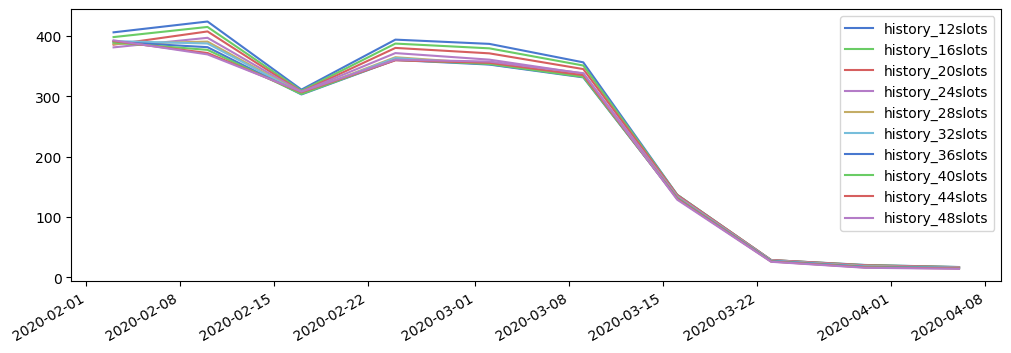

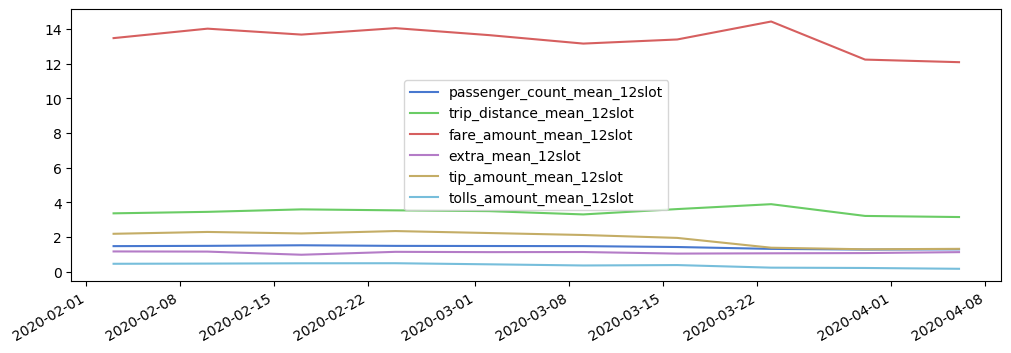

In [19]:
# Statisticsレポートを取得
statistics_reports = get_reports(bucket, report_prefix, 'statistics')

# 特定のmetricを取得
df_mean = extract_stats_value(feature_names, statistics_reports, 'mean')

# 推移をプロット
history_cols = [x for x in df_mean.columns if x.startswith('history')][:10]
df_mean[history_cols].plot(figsize=(12,4))

other_cols = [x for x in df_mean.columns if not x.startswith('history') and x.endswith('12slot')][:10]
df_mean[other_cols].plot(figsize=(12,4))

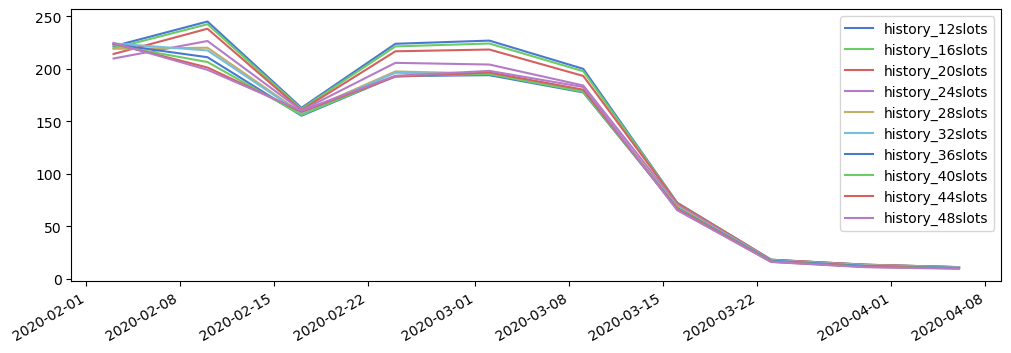

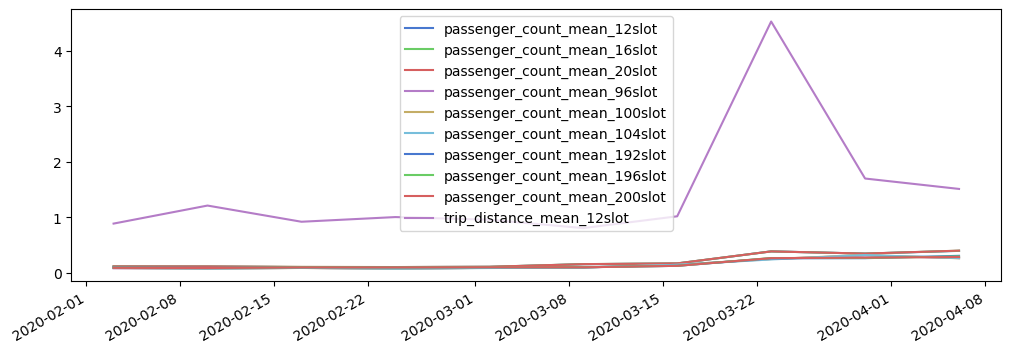

In [20]:
df_std_dev = extract_stats_value(feature_names, statistics_reports, 'std_dev')

history_cols = [x for x in df_std_dev.columns if x.startswith('history')][:10]
df_std_dev[history_cols].plot(figsize=(12,4))

other_cols = [x for x in df_std_dev.columns if not(x.startswith('history') or x.startswith('weekday') or x=='pickup_count')][:10]
df_std_dev[other_cols].plot(figsize=(12,4))